Best score 0.7981 model LogisticRegression

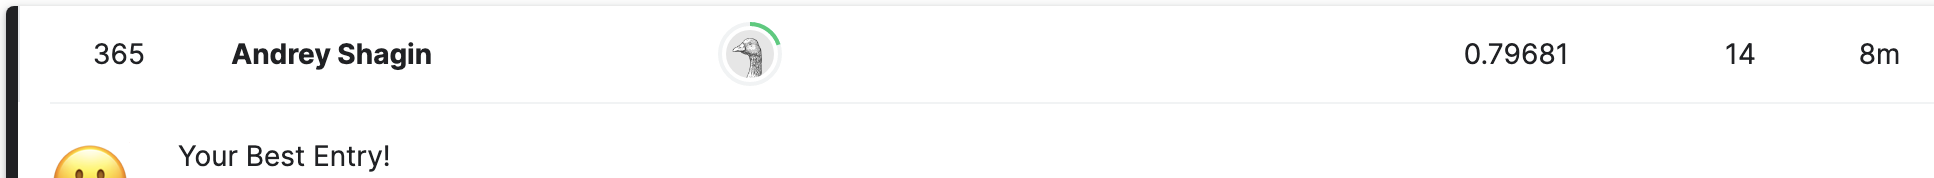

# imports, file load

In [1]:
import pandas as pd


In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test_kaggle = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [4]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re
import torch
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm import notebook

# Basic EDA

In [5]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


NaN in keyword and location, but I will use just text column as feature, so no need to deal with Nan here

In [7]:
df.isna().mean()

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [8]:
df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [9]:
df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

Target not exactly 50/50 balance, so I will use stratify 

In [10]:
df['target'].value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

# clear, lemmatize

First I clear text from all symbols besides letters.

In [11]:
def clear_text(text):
    clear = re.sub (r'[^a-zA-Z]', ' ',text)
    clear_split = clear.split()
    clear_join = " ".join (clear_split)
    return clear_join.lower()

In [12]:
df['text_clean'] = df['text'].apply(clear_text)
test_kaggle['text_clean'] = test_kaggle['text'].apply(clear_text)


In [13]:
df

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest the out of control wil...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utc km s of volcano hawaii http t co zdtoyd ebj
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...


Next I delete stopwords

In [14]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
stopwords = stopwords.words('english')

In [16]:
df['text_clean_stop_words'] = df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
test_kaggle['text_clean_stop_words'] = test_kaggle['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [17]:
df

,id,keyword,location,text,target,text_clean,text_clean_stop_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,two giant cranes holding bridge collapse nearb...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest the out of control wil...,aria ahrary thetawniest control wild fires cal...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utc km s of volcano hawaii http t co zdtoyd ebj,utc km volcano hawaii http co zdtoyd ebj
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...,police investigating e bike collided car littl...


After lemmatization with POS tags for noun, verb and so on, in order to proper define basic form of each word

In [18]:
lemmatizer = WordNetLemmatizer()

In [19]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [20]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [21]:
def lemmatize (text):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [24]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [25]:
df['text_lemmatize'] = df['text_clean_stop_words'].apply(lemmatize)
test_kaggle['text_lemmatize'] = test_kaggle['text_clean_stop_words'].apply(lemmatize)

In [26]:
df

,id,keyword,location,text,target,text_clean,text_clean_stop_words,text_lemmatize
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,deeds reason earthquake may allah forgive us,deed reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,residents asked shelter place notified officer...,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,people receive wildfires evacuation orders cal...,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfires pou...,get sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,two giant cranes holding bridge collapse nearb...,two giant crane hold bridge collapse nearby ho...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest the out of control wil...,aria ahrary thetawniest control wild fires cal...,aria ahrary thetawniest control wild fire cali...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utc km s of volcano hawaii http t co zdtoyd ebj,utc km volcano hawaii http co zdtoyd ebj,utc km volcano hawaii http co zdtoyd ebj
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...,police investigating e bike collided car littl...,police investigate e bike collide car little p...


In [27]:
def split(text):
    text_split = text.split()
    return text_split

In [28]:
df['text_split'] = df['text_lemmatize'].apply(split)
test_kaggle['text_split'] = test_kaggle['text_lemmatize'].apply(split)

# Top common words

In [29]:
df

,id,keyword,location,text,target,text_clean,text_clean_stop_words,text_lemmatize,text_split
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,deeds reason earthquake may allah forgive us,deed reason earthquake may allah forgive us,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,residents asked shelter place notified officer...,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,people receive wildfires evacuation orders cal...,people receive wildfire evacuation order calif...,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfires pou...,get sent photo ruby alaska smoke wildfires pou...,"[get, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,two giant cranes holding bridge collapse nearb...,two giant crane hold bridge collapse nearby ho...,"[two, giant, crane, hold, bridge, collapse, ne..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest the out of control wil...,aria ahrary thetawniest control wild fires cal...,aria ahrary thetawniest control wild fire cali...,"[aria, ahrary, thetawniest, control, wild, fir..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utc km s of volcano hawaii http t co zdtoyd ebj,utc km volcano hawaii http co zdtoyd ebj,utc km volcano hawaii http co zdtoyd ebj,"[utc, km, volcano, hawaii, http, co, zdtoyd, ebj]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...,police investigating e bike collided car littl...,police investigate e bike collide car little p...,"[police, investigate, e, bike, collide, car, l..."


In [30]:
words = df['text_split']
allwords = []
for wordlist in words:
    allwords += wordlist


In [31]:
from nltk.probability import FreqDist

There are 'co' and 'http' popular words in both targets, I'll delete them. Cause these words don't add sense in defining disaster tweet from not.

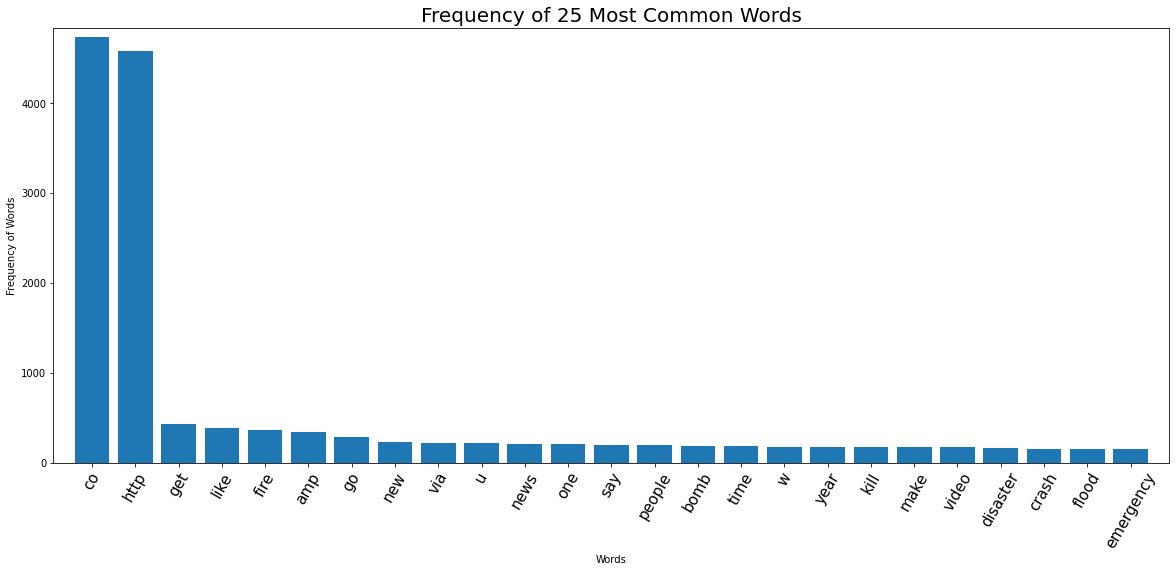

In [32]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(20,8))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency of Words', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=60, fontsize=15)
plt.title('Frequency of 25 Most Common Words', fontsize=20)
plt.show()

In [33]:
def check(word, list):
    if word in list:
        print("The word is in the list!")
    else:
        print("The word is not in the list!")

In [34]:
check ('http', allwords)

The word is in the list!


In [35]:
from collections import Counter

In [36]:
counts = Counter(allwords).most_common(25)
display(counts)

[('co', 4744),
 ('http', 4581),
 ('get', 438),
 ('like', 393),
 ('fire', 363),
 ('amp', 344),
 ('go', 288),
 ('new', 234),
 ('via', 220),
 ('u', 216),
 ('news', 213),
 ('one', 209),
 ('say', 202),
 ('people', 201),
 ('bomb', 189),
 ('time', 183),
 ('w', 179),
 ('year', 178),
 ('kill', 178),
 ('make', 177),
 ('video', 173),
 ('disaster', 162),
 ('crash', 160),
 ('flood', 159),
 ('emergency', 159)]

In [37]:
df

,id,keyword,location,text,target,text_clean,text_clean_stop_words,text_lemmatize,text_split
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,deeds reason earthquake may allah forgive us,deed reason earthquake may allah forgive us,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,residents asked shelter place notified officer...,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,people receive wildfires evacuation orders cal...,people receive wildfire evacuation order calif...,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfires pou...,get sent photo ruby alaska smoke wildfires pou...,"[get, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,two giant cranes holding bridge collapse nearb...,two giant crane hold bridge collapse nearby ho...,"[two, giant, crane, hold, bridge, collapse, ne..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest the out of control wil...,aria ahrary thetawniest control wild fires cal...,aria ahrary thetawniest control wild fire cali...,"[aria, ahrary, thetawniest, control, wild, fir..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utc km s of volcano hawaii http t co zdtoyd ebj,utc km volcano hawaii http co zdtoyd ebj,utc km volcano hawaii http co zdtoyd ebj,"[utc, km, volcano, hawaii, http, co, zdtoyd, ebj]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...,police investigating e bike collided car littl...,police investigate e bike collide car little p...,"[police, investigate, e, bike, collide, car, l..."


In [38]:
stopwords_updated = ('http', 'co', 'https')

In [39]:
df['text_lemmatize_updated'] = df['text_lemmatize'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_updated)]))
test_kaggle['text_lemmatize_updated'] = test_kaggle['text_lemmatize'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_updated)]))

In [40]:
df['text_split_updated'] = df['text_lemmatize_updated'].apply(split)

In [41]:
words_update = df['text_split_updated']
allwords_updated = []
for wordlist in words_update:
    allwords_updated += wordlist

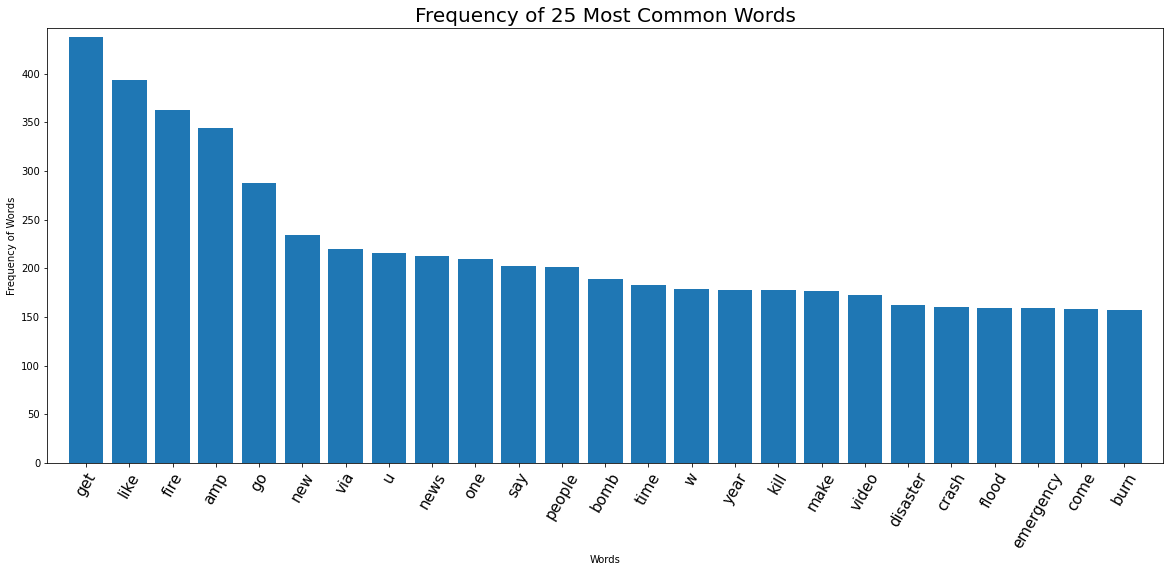

In [42]:
mostcommon_small = FreqDist(allwords_updated).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(20,8))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency of Words', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=60, fontsize=15)
plt.title('Frequency of 25 Most Common Words', fontsize=20)
plt.show()

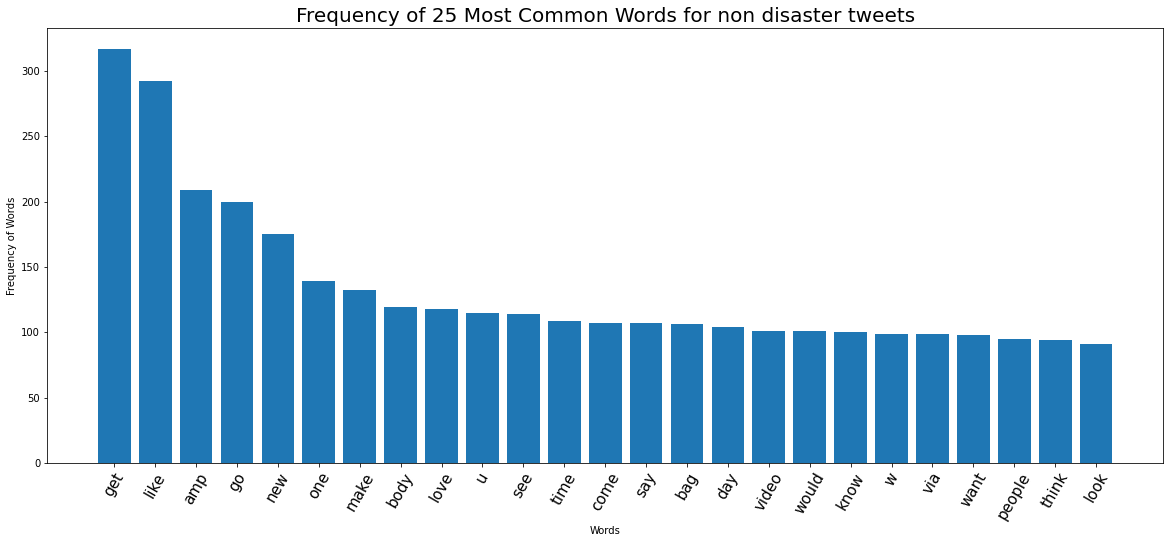

In [43]:
group_by = df.groupby('target')['text_lemmatize_updated'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(20,8))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency of Words', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=60, fontsize=15)
plt.title('Frequency of 25 Most Common Words for non disaster tweets', fontsize=20)
plt.show()

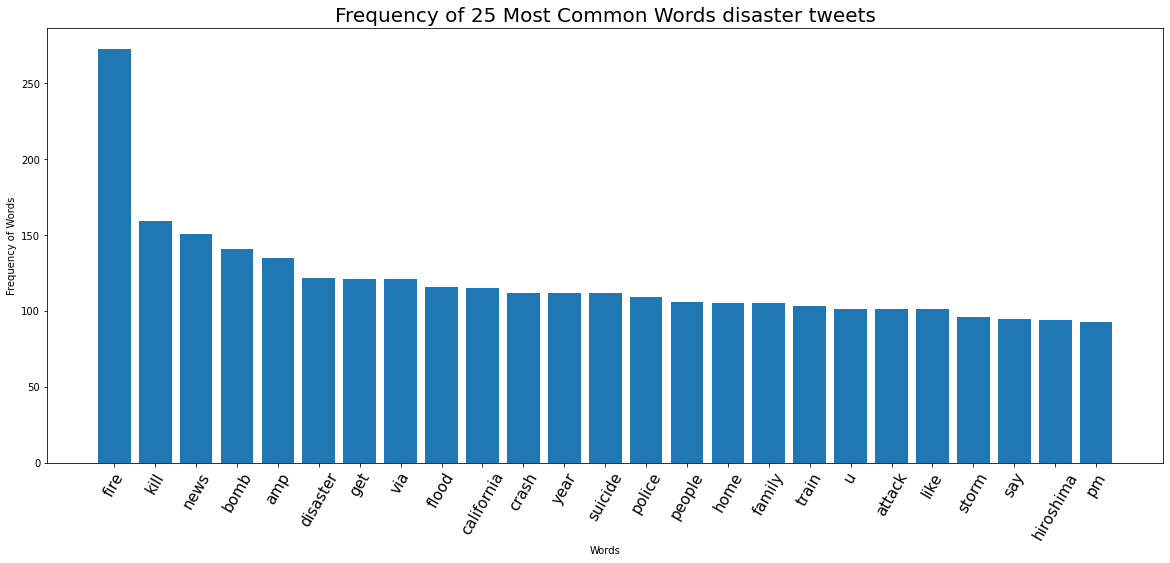

In [44]:
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]
plt.figure(figsize=(20,8))
plt.bar(words1, freq1)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency of Words', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=60, fontsize=15)
plt.title('Frequency of 25 Most Common Words disaster tweets', fontsize=20)
plt.show()

In [45]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from wordcloud import WordCloud

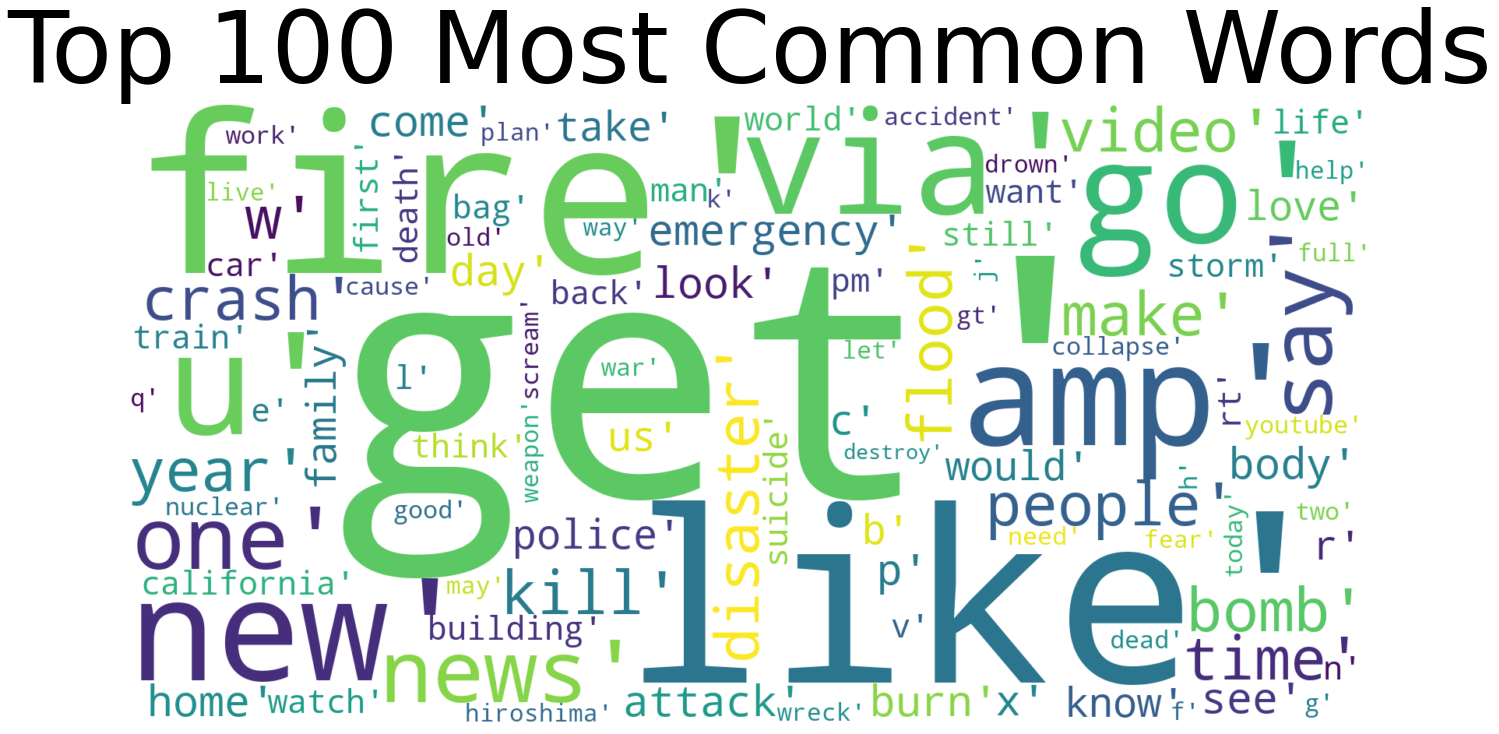

In [47]:
mostcommon = FreqDist(allwords_updated).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

# Train, test split

Split for train/test 80/20 with stratify to safe balance in target

In [48]:
features = df['text_lemmatize_updated']
target = df['target']
test_kaggle_features = test_kaggle['text_lemmatize_updated']

In [49]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=42, stratify = df['target'])

In [50]:
def check_size (frames, start_frame):
    return display ("{0:.0%}".format(len(frames)/len(start_frame)))
print ('Features')
check_size (features_train, features)

check_size (features_test, features)
print ('Test')
check_size (target_train, target)

check_size (target_test, target)

Features


'80%'

'20%'

Test


'80%'

'20%'

Apply TfidfVectorizer to determine how relevant those words are to a given data

In [51]:
count_tf_idf = TfidfVectorizer()

In [52]:
count_tf_idf

TfidfVectorizer()

In [53]:
features_train_vector = count_tf_idf.fit_transform(features_train)
features_test_vector = count_tf_idf.transform(features_test)
features_test_kaggle = count_tf_idf.transform(test_kaggle_features)

# LogisticRegression

In [54]:
model_lr = LogisticRegression(random_state=42)

In [55]:
model_lr.fit (features_train_vector, target_train)

LogisticRegression(random_state=42)

In [56]:
model_lr_pred = model_lr.predict(features_test_vector)
lr_f1 = f1_score(target_test, model_lr_pred)
lr_f1

0.7611940298507464

In [57]:
def confmatrix(pred,model_name):
  cm = confusion_matrix(target_test, pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_name.classes_)
  disp.plot(cmap='Blues')
  plt.show()
  print(classification_report(target_test, pred, zero_division = 0))

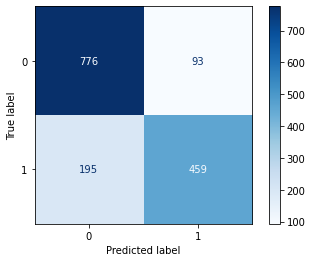

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       869
           1       0.83      0.70      0.76       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



In [58]:
confmatrix(model_lr_pred,model_lr)

In [59]:
parameters_lr = {'C': [3,5,7,9]}

In [60]:
grid_lr = GridSearchCV(model_lr, param_grid=parameters_lr, scoring='f1',verbose=3, cv=3)

In [61]:
grid_lr.fit (features_train_vector, target_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ...............................C=3;, score=0.710 total time=   0.2s
[CV 2/3] END ...............................C=3;, score=0.734 total time=   0.2s
[CV 3/3] END ...............................C=3;, score=0.726 total time=   0.3s
[CV 1/3] END ...............................C=5;, score=0.715 total time=   0.2s
[CV 2/3] END ...............................C=5;, score=0.738 total time=   0.4s
[CV 3/3] END ...............................C=5;, score=0.729 total time=   0.3s
[CV 1/3] END ...............................C=7;, score=0.721 total time=   0.5s
[CV 2/3] END ...............................C=7;, score=0.734 total time=   0.3s
[CV 3/3] END ...............................C=7;, score=0.727 total time=   0.2s
[CV 1/3] END ...............................C=9;, score=0.718 total time=   0.5s
[CV 2/3] END ...............................C=9;, score=0.735 total time=   0.3s
[CV 3/3] END ...............................C=9;,

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [3, 5, 7, 9]}, scoring='f1', verbose=3)

In [62]:
lr_f1_grid = grid_lr.best_score_

In [63]:
lr_f1_grid

0.7273015695508852

In [64]:
grid_lr.best_params_

{'C': 7}

In [65]:
model_lr_grid = LogisticRegression(C = 7, class_weight = 'balanced', max_iter=100, penalty= 'l2',random_state=42)

In [66]:
model_lr_grid.fit (features_train_vector, target_train)

LogisticRegression(C=7, class_weight='balanced', random_state=42)

In [67]:
model_lr_grid_pred = model_lr_grid.predict(features_test_vector)
lr_grid_f1 = f1_score(target_test, model_lr_grid_pred)
lr_grid_f1

0.7681818181818181

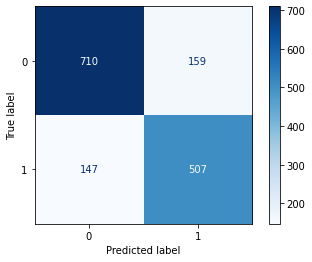

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       869
           1       0.76      0.78      0.77       654

    accuracy                           0.80      1523
   macro avg       0.79      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



In [68]:
confmatrix(model_lr_grid_pred,model_lr_grid)

# DecisionTreeClassifier

In [69]:
model_tree = DecisionTreeClassifier(random_state = 42)

In [70]:
model_tree.fit (features_train_vector, target_train)

DecisionTreeClassifier(random_state=42)

In [71]:
model_tree_pred = model_tree.predict(features_test_vector)
tree_f1 = f1_score(target_test, model_tree_pred)
tree_f1

0.6927122464312547

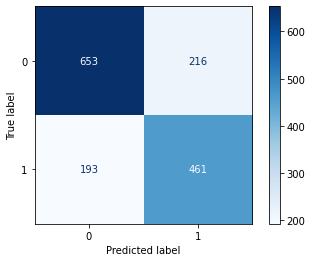

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       869
           1       0.68      0.70      0.69       654

    accuracy                           0.73      1523
   macro avg       0.73      0.73      0.73      1523
weighted avg       0.73      0.73      0.73      1523



In [72]:
confmatrix(model_tree_pred,model_tree)

In [73]:
criterion=['gini', 'entropy']
max_depth=[30,35,45,50]
min_samples_split=[7,8,9,11]
min_samples_leaf=[1,3,7,9]
param_grid={'max_depth':max_depth,
            'min_samples_split':min_samples_split,
           'min_samples_leaf':min_samples_leaf,
           'criterion':criterion}

In [74]:
grid=GridSearchCV(DecisionTreeClassifier(),param_grid,n_jobs=-1,cv=3,verbose=200)
grid.fit(features_train_vector, target_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [30, 35, 45, 50],
                         'min_samples_leaf': [1, 3, 7, 9],
                         'min_samples_split': [7, 8, 9, 11]},
             verbose=200)

In [75]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 8}

In [76]:
grid.best_score_

0.7444991789819376

In [77]:
model_tree_grid = DecisionTreeClassifier(random_state = 42,
                                         criterion = 'gini',
                                         max_depth = 35,
                                         min_samples_leaf = 1,
                                         min_samples_split = 9)

In [78]:
model_tree_grid.fit (features_train_vector, target_train)

DecisionTreeClassifier(max_depth=35, min_samples_split=9, random_state=42)

In [79]:
model_tree_grid_pred = model_tree_grid.predict(features_test_vector)
tree__grid_f1 = f1_score(target_test, model_tree_grid_pred)
tree__grid_f1

0.6272300469483568

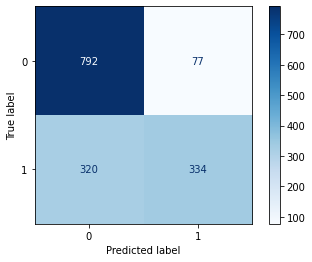

              precision    recall  f1-score   support

           0       0.71      0.91      0.80       869
           1       0.81      0.51      0.63       654

    accuracy                           0.74      1523
   macro avg       0.76      0.71      0.71      1523
weighted avg       0.76      0.74      0.73      1523



In [80]:
confmatrix(model_tree_grid_pred,model_tree_grid)

# CatBoost

In [81]:
pip install catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [82]:
from catboost import CatBoostClassifier

In [83]:
model_cat = CatBoostClassifier(verbose=100, random_seed=42)

In [84]:
model_cat.fit (features_train_vector, target_train)

Learning rate set to 0.022283
0:	learn: 0.6908980	total: 149ms	remaining: 2m 29s
100:	learn: 0.6002646	total: 17.8s	remaining: 2m 38s
200:	learn: 0.5634923	total: 38.5s	remaining: 2m 33s
300:	learn: 0.5387724	total: 49.1s	remaining: 1m 53s
400:	learn: 0.5161956	total: 59.6s	remaining: 1m 28s
500:	learn: 0.4937098	total: 1m 10s	remaining: 1m 9s
600:	learn: 0.4733631	total: 1m 20s	remaining: 53.5s
700:	learn: 0.4567483	total: 1m 31s	remaining: 38.9s
800:	learn: 0.4411016	total: 1m 42s	remaining: 25.3s
900:	learn: 0.4284523	total: 1m 55s	remaining: 12.7s
999:	learn: 0.4167990	total: 2m 5s	remaining: 0us


In [85]:
model_cat_pred = model_cat.predict(features_test_vector)
cat_f1 = f1_score(target_test, model_cat_pred)
cat_f1

0.7348993288590604

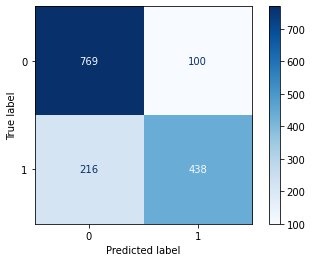

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       869
           1       0.81      0.67      0.73       654

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [86]:
confmatrix(model_cat_pred,model_cat)

In [87]:
model_cat2 = CatBoostClassifier(learning_rate=0.1,
                          depth=4,
                         verbose = 100,
                              random_seed=42,
                              eval_metric = 'F1')

In [88]:
model_cat2.fit (features_train_vector, target_train)

0:	learn: 0.2238315	total: 44.6ms	remaining: 44.5s
100:	learn: 0.6618671	total: 5.7s	remaining: 50.7s
200:	learn: 0.7472478	total: 14.3s	remaining: 56.9s
300:	learn: 0.7907180	total: 23.1s	remaining: 53.7s
400:	learn: 0.8217885	total: 33.1s	remaining: 49.4s
500:	learn: 0.8437765	total: 39.6s	remaining: 39.4s
600:	learn: 0.8622855	total: 44.3s	remaining: 29.4s
700:	learn: 0.8781399	total: 48.8s	remaining: 20.8s
800:	learn: 0.8884766	total: 53.3s	remaining: 13.2s
900:	learn: 0.8966509	total: 57.8s	remaining: 6.35s
999:	learn: 0.9037674	total: 1m 2s	remaining: 0us


In [89]:
model_cat2_pred = model_cat2.predict(features_test_vector)
cat_f12 = f1_score(target_test, model_cat2_pred)
cat_f12

0.7526020816653323

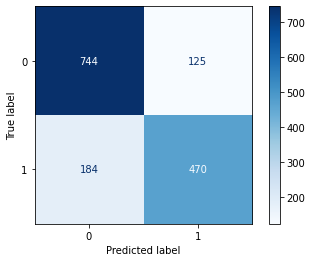

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       869
           1       0.79      0.72      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [90]:
confmatrix(model_cat2_pred,model_cat2)

In [91]:
from catboost import Pool
from catboost import cv

In [92]:
train_data = Pool(data=features_train_vector,
              label=target_train
              )

In [93]:
model_params = {'random_state': 42,
                'eval_metric': 'F1',
                'verbose': 100,
                'loss_function': 'Logloss',
                'learning_rate': 0.08}

In [94]:
cv_params = {'params': model_params,
             'pool': train_data,
             'fold_count': 3,
             'shuffle':True,
             'partition_random_seed':42,
             'stratified':True,
             'verbose': 100,
             'early_stopping_rounds':200}

In [95]:
cv_data = cv(**cv_params)

Training on fold [0/3]
0:	learn: 0.2015113	test: 0.2084168	best: 0.2084168 (0)	total: 74.3ms	remaining: 1m 14s
100:	learn: 0.6530612	test: 0.6192223	best: 0.6192223 (100)	total: 6.96s	remaining: 1m 1s
200:	learn: 0.7700643	test: 0.6834925	best: 0.6834925 (199)	total: 13.2s	remaining: 52.4s
300:	learn: 0.8246415	test: 0.6969697	best: 0.6979511 (290)	total: 19.4s	remaining: 45.1s
400:	learn: 0.8653785	test: 0.7076326	best: 0.7097608 (394)	total: 25.6s	remaining: 38.3s
500:	learn: 0.8910336	test: 0.7091377	best: 0.7104247 (493)	total: 31.9s	remaining: 31.8s
600:	learn: 0.9054388	test: 0.7126437	best: 0.7134652 (596)	total: 38.1s	remaining: 25.3s
700:	learn: 0.9137243	test: 0.7156550	best: 0.7189293 (689)	total: 44.2s	remaining: 18.9s
800:	learn: 0.9272007	test: 0.7133758	best: 0.7189293 (689)	total: 50.4s	remaining: 12.5s
900:	learn: 0.9402535	test: 0.7173638	best: 0.7196440 (883)	total: 59.1s	remaining: 6.49s
999:	learn: 0.9744943	test: 0.7134725	best: 0.7196440 (883)	total: 1m 5s	remain

In [96]:
model_cat_cv = CatBoostClassifier(**model_params)

In [97]:
model_cat_cv.fit(train_data)

0:	learn: 0.2686281	total: 101ms	remaining: 1m 41s
100:	learn: 0.6551227	total: 10.6s	remaining: 1m 34s
200:	learn: 0.7591436	total: 21.1s	remaining: 1m 23s
300:	learn: 0.8046926	total: 32.3s	remaining: 1m 14s
400:	learn: 0.8390658	total: 51.1s	remaining: 1m 16s
500:	learn: 0.8637693	total: 1m 1s	remaining: 1m 1s
600:	learn: 0.8821340	total: 1m 13s	remaining: 48.9s
700:	learn: 0.8947801	total: 1m 24s	remaining: 36.1s
800:	learn: 0.9010043	total: 1m 41s	remaining: 25.2s
900:	learn: 0.9109072	total: 1m 54s	remaining: 12.6s
999:	learn: 0.9200487	total: 2m 8s	remaining: 0us


In [98]:
model_cat_cv_pred = model_cat_cv.predict(features_test_vector)
cat_cv_f1 = f1_score(target_test, model_cat_cv_pred)
cat_cv_f1

0.7563694267515924

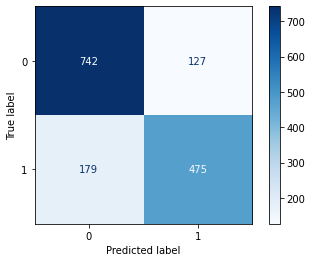

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       869
           1       0.79      0.73      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [99]:
confmatrix(model_cat_cv_pred,model_cat_cv)

# LGBM

In [100]:
from lightgbm import LGBMClassifier

In [101]:
LGBM_model = LGBMClassifier(
                      random_state=42)

In [102]:
LGBM_model.fit(features_train_vector, target_train)

LGBMClassifier(random_state=42)

In [103]:
LGBM_model_pred = LGBM_model.predict(features_test_vector)
f1_LGBM = f1_score(target_test, LGBM_model_pred)
f1_LGBM

0.7431874483897605

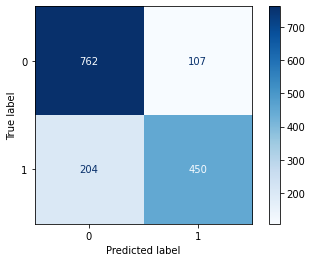

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.81      0.69      0.74       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [104]:
confmatrix(LGBM_model_pred,LGBM_model)

In [105]:
regressor = LGBMClassifier( 
    random_state=42) 
hyperparams = [{'max_depth': [1, 2, 3, 30, 35, 50, 80, 100],
                'num_leaves': [2, 4, 6, 60, 70, 100, 160, 200],
                'learning_rate': [0.025, 0.05, 0.5,0.1, 0.12],
}]

clf = GridSearchCV(regressor, hyperparams, scoring='f1', cv=3)
clf.fit(features_train_vector, target_train)
print(clf.best_params_)

{'learning_rate': 0.1, 'max_depth': 100, 'num_leaves': 100}


In [106]:
    # boosting_type='gbdt',
    # num_leaves=31,
    # max_depth=-1,
    # learning_rate=0.1,
    # n_estimators=100,
    # objective='binary', # The default is two categories
    # min_split_gain=0.0,
    # min_child_samples=20,
    # subsample=1.0,
    # subsample_freq=0,
    # colsample_bytree=1.0,
    # reg_alpha=0.0,
    # reg_lambda=0.0,
    # random_state=None,
    # silent=True

In [107]:
LGBM_model_grid = LGBMClassifier(learning_rate = 0.1, max_depth = 100, 
                      random_state=42, num_leaves = 200)

In [108]:
LGBM_model_grid.fit(features_train_vector, target_train)

LGBMClassifier(max_depth=100, num_leaves=200, random_state=42)

In [109]:
LGBM_model_grid_pred = LGBM_model_grid.predict(features_test_vector)
f1_LGBM_grid = f1_score(target_test, LGBM_model_grid_pred)
f1_LGBM_grid

0.7438540840602696

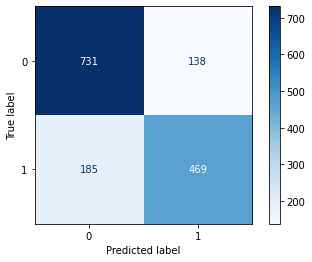

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       869
           1       0.77      0.72      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [110]:
confmatrix(LGBM_model_grid_pred,LGBM_model_grid)

In [111]:
from tabulate import tabulate

In [112]:
mydata = [
    ["LGBM_model_grid", f1_LGBM_grid],
    ["LGBM_model", f1_LGBM],
    ["model_catboost_cv", cat_cv_f1],
      ["model_catboost1", cat_f1],
      ["model_catboost2", cat_f12],
      ["DecisionTree", tree_f1],
      ["DecisionTree_grid", tree__grid_f1],
      ["LogicRegression", lr_f1],
      ["LogicRegression_grid", lr_grid_f1]
]
head = ["Model", "Test f1 score"]


In [128]:
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------+-----------------+
| Model                |   Test f1 score |
+======================+=================+
| LGBM_model_grid      |        0.743854 |
+----------------------+-----------------+
| LGBM_model           |        0.743187 |
+----------------------+-----------------+
| model_catboost_cv    |        0.756369 |
+----------------------+-----------------+
| model_catboost1      |        0.734899 |
+----------------------+-----------------+
| model_catboost2      |        0.752602 |
+----------------------+-----------------+
| DecisionTree         |        0.692712 |
+----------------------+-----------------+
| DecisionTree_grid    |        0.62723  |
+----------------------+-----------------+
| LogicRegression      |        0.761194 |
+----------------------+-----------------+
| LogicRegression_grid |        0.768182 |
+----------------------+-----------------+


In [151]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [152]:
import io
sample_submission = pd.read_csv(io.BytesIO(uploaded['sample_submission.csv']))

In [153]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


# Submission

In [155]:
#model_lr
#model_lr_grid
#model_tree
#model_tree_grid
#model_cat
#model_cat2
#model_cat_cv
#LGBM_model
#LGBM_model_grid

In [156]:
sample_submission["target"] = model_lr.predict(features_test_kaggle)

In [157]:
sample_submission.to_csv("submission20112022_lr.csv", index=False)

In [158]:
from google.colab import files
files.download("submission20112022_lr.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>